In [4]:
import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import PoisonDataset
from simclr import SimClrBackbone

In [3]:
device = "cuda"
epochs = 1000
batch_size = 128

## SimCLR data augmentations

## Poison dataset with BadNets

In [2]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)
poison_dataset = PoisonDataset(dataset, 0, "triggers/trigger_white.png", seed=1, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [5]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [7]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [8]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [9]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

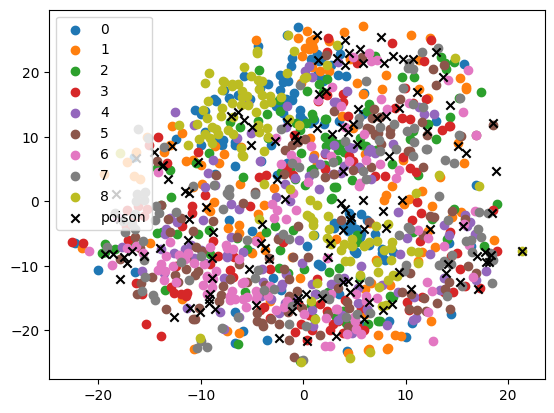

In [10]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true
    labels[labels_true != labels_poison] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [127]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [128]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [131]:
start_epoch = 1

load_checkpoint = True
checkpoint_name = "SimCLR_50.pt"

if load_checkpoint:
    out = os.path.join('./saved_models/', checkpoint_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [50/1000]	
	Step [0/391]	 Loss: 3.6235
	Step [50/391]	 Loss: 3.62122
	Step [100/391]	 Loss: 3.62682
	Step [150/391]	 Loss: 3.6182
	Step [200/391]	 Loss: 3.6234
	Step [250/391]	 Loss: 3.62236
	Step [300/391]	 Loss: 3.61694
	Step [350/391]	 Loss: 3.62847
	Epoch [50/1000]	 Training Loss: 3.619861680833275
	Epoch [50/1000]	 Time Taken: 3.9220999836921693 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/SimCLR_50.pt


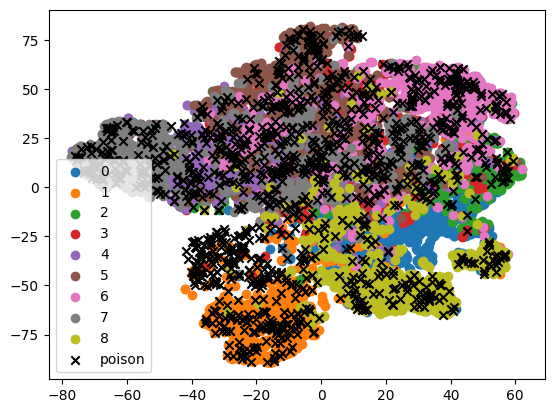

Epoch [51/1000]	
	Step [0/391]	 Loss: 3.62205
	Step [50/391]	 Loss: 3.62634
	Step [100/391]	 Loss: 3.62787
	Step [150/391]	 Loss: 3.62462
	Step [200/391]	 Loss: 3.61773
	Step [250/391]	 Loss: 3.61818
	Step [300/391]	 Loss: 3.61963
	Step [350/391]	 Loss: 3.61846
	Epoch [51/1000]	 Training Loss: 3.6191945575997044
	Epoch [51/1000]	 Time Taken: 3.9597880681355795 minutes
Epoch [52/1000]	
	Step [0/391]	 Loss: 3.6207
	Step [50/391]	 Loss: 3.6223
	Step [100/391]	 Loss: 3.61057
	Step [150/391]	 Loss: 3.61862
	Step [200/391]	 Loss: 3.6154
	Step [250/391]	 Loss: 3.62035
	Step [300/391]	 Loss: 3.61884
	Step [350/391]	 Loss: 3.61929
	Epoch [52/1000]	 Training Loss: 3.618803617594492
	Epoch [52/1000]	 Time Taken: 3.9311833063761394 minutes
Epoch [53/1000]	
	Step [0/391]	 Loss: 3.61473
	Step [50/391]	 Loss: 3.62228
	Step [100/391]	 Loss: 3.61439
	Step [150/391]	 Loss: 3.62309
	Step [200/391]	 Loss: 3.62337
	Step [250/391]	 Loss: 3.62317
	Step [300/391]	 Loss: 3.6218
	Step [350/391]	 Loss: 3.61666
	

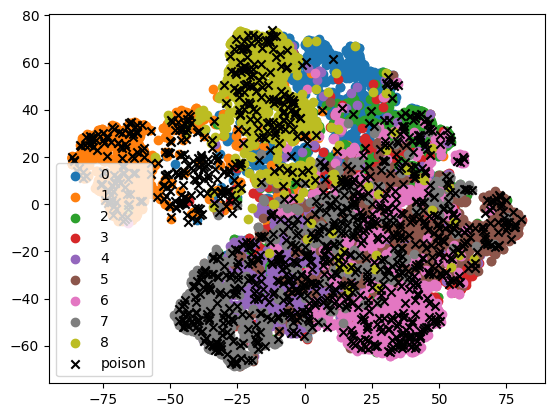

Epoch [61/1000]	
	Step [0/391]	 Loss: 3.6135
	Step [50/391]	 Loss: 3.62132
	Step [100/391]	 Loss: 3.62084
	Step [150/391]	 Loss: 3.61048
	Step [200/391]	 Loss: 3.6082
	Step [250/391]	 Loss: 3.61576
	Step [300/391]	 Loss: 3.61542
	Step [350/391]	 Loss: 3.62087
	Epoch [61/1000]	 Training Loss: 3.6152976955599185
	Epoch [61/1000]	 Time Taken: 3.9870625416437786 minutes
Epoch [62/1000]	
	Step [0/391]	 Loss: 3.61435
	Step [50/391]	 Loss: 3.61205
	Step [100/391]	 Loss: 3.61497
	Step [150/391]	 Loss: 3.61564
	Step [200/391]	 Loss: 3.61436
	Step [250/391]	 Loss: 3.62301
	Step [300/391]	 Loss: 3.61716
	Step [350/391]	 Loss: 3.62025
	Epoch [62/1000]	 Training Loss: 3.615207894074033
	Epoch [62/1000]	 Time Taken: 3.986631182829539 minutes
Epoch [63/1000]	
	Step [0/391]	 Loss: 3.6077
	Step [50/391]	 Loss: 3.61589
	Step [100/391]	 Loss: 3.61956
	Step [150/391]	 Loss: 3.61211
	Step [200/391]	 Loss: 3.62105
	Step [250/391]	 Loss: 3.60773
	Step [300/391]	 Loss: 3.61651
	Step [350/391]	 Loss: 3.62605
	

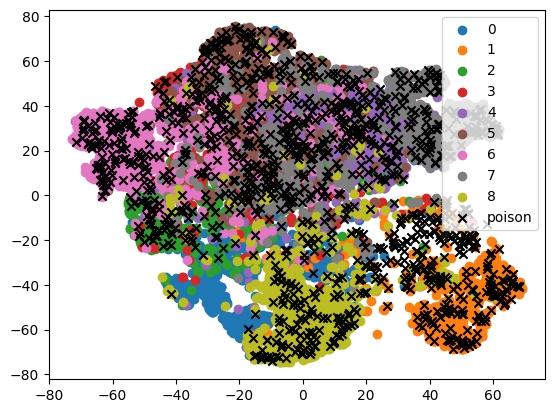

Epoch [71/1000]	
	Step [0/391]	 Loss: 3.61095
	Step [50/391]	 Loss: 3.61323
	Step [100/391]	 Loss: 3.61655
	Step [150/391]	 Loss: 3.61814
	Step [200/391]	 Loss: 3.61007
	Step [250/391]	 Loss: 3.60857
	Step [300/391]	 Loss: 3.61118
	Step [350/391]	 Loss: 3.61846
	Epoch [71/1000]	 Training Loss: 3.612360872575999
	Epoch [71/1000]	 Time Taken: 3.9822873433430988 minutes
Epoch [72/1000]	
	Step [0/391]	 Loss: 3.61552
	Step [50/391]	 Loss: 3.61795
	Step [100/391]	 Loss: 3.60806
	Step [150/391]	 Loss: 3.60802
	Step [200/391]	 Loss: 3.60617
	Step [250/391]	 Loss: 3.61345
	Step [300/391]	 Loss: 3.61114
	Step [350/391]	 Loss: 3.61379
	Epoch [72/1000]	 Training Loss: 3.6121771158769613
	Epoch [72/1000]	 Time Taken: 3.9911120414733885 minutes
Epoch [73/1000]	
	Step [0/391]	 Loss: 3.60966
	Step [50/391]	 Loss: 3.61644
	Step [100/391]	 Loss: 3.61614
	Step [150/391]	 Loss: 3.61261
	Step [200/391]	 Loss: 3.61935
	Step [250/391]	 Loss: 3.61573
	Step [300/391]	 Loss: 3.60446
	Step [350/391]	 Loss: 3.614

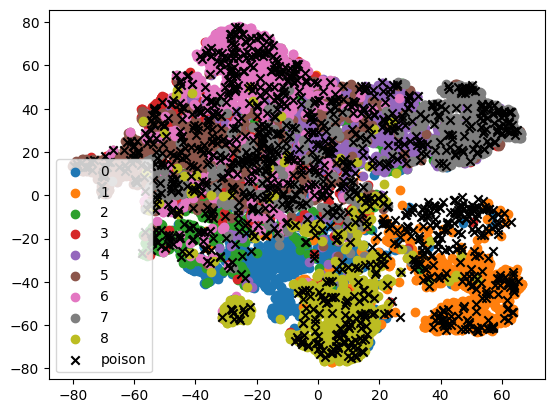

Epoch [81/1000]	
	Step [0/391]	 Loss: 3.60467
	Step [50/391]	 Loss: 3.61425
	Step [100/391]	 Loss: 3.61519
	Step [150/391]	 Loss: 3.60868
	Step [200/391]	 Loss: 3.61719
	Step [250/391]	 Loss: 3.60621
	Step [300/391]	 Loss: 3.61398
	Step [350/391]	 Loss: 3.60995
	Epoch [81/1000]	 Training Loss: 3.609564870214828
	Epoch [81/1000]	 Time Taken: 4.000024580955506 minutes
Epoch [82/1000]	
	Step [0/391]	 Loss: 3.60554
	Step [50/391]	 Loss: 3.60458
	Step [100/391]	 Loss: 3.60864
	Step [150/391]	 Loss: 3.60842
	Step [200/391]	 Loss: 3.6114
	Step [250/391]	 Loss: 3.61369
	Step [300/391]	 Loss: 3.60506
	Step [350/391]	 Loss: 3.6097
	Epoch [82/1000]	 Training Loss: 3.6093946234954286
	Epoch [82/1000]	 Time Taken: 4.002771743138632 minutes
Epoch [83/1000]	
	Step [0/391]	 Loss: 3.6129
	Step [50/391]	 Loss: 3.61461
	Step [100/391]	 Loss: 3.60788
	Step [150/391]	 Loss: 3.6134
	Step [200/391]	 Loss: 3.61134
	Step [250/391]	 Loss: 3.60424
	Step [300/391]	 Loss: 3.61368
	Step [350/391]	 Loss: 3.60834
	Ep

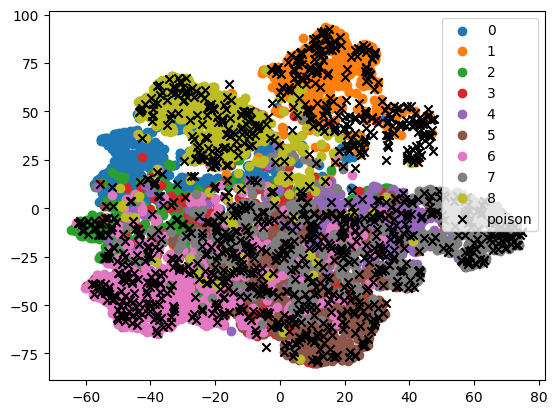

Epoch [91/1000]	
	Step [0/391]	 Loss: 3.60947
	Step [50/391]	 Loss: 3.60781
	Step [100/391]	 Loss: 3.61304
	Step [150/391]	 Loss: 3.60605
	Step [200/391]	 Loss: 3.60775
	Step [250/391]	 Loss: 3.60936
	Step [300/391]	 Loss: 3.60685
	Step [350/391]	 Loss: 3.60147
	Epoch [91/1000]	 Training Loss: 3.607591843056252
	Epoch [91/1000]	 Time Taken: 3.998581254482269 minutes
Epoch [92/1000]	
	Step [0/391]	 Loss: 3.61339
	Step [50/391]	 Loss: 3.60582
	Step [100/391]	 Loss: 3.613
	Step [150/391]	 Loss: 3.61221
	Step [200/391]	 Loss: 3.60767
	Step [250/391]	 Loss: 3.60686
	Step [300/391]	 Loss: 3.60962
	Step [350/391]	 Loss: 3.61141
	Epoch [92/1000]	 Training Loss: 3.607223108296504
	Epoch [92/1000]	 Time Taken: 3.999922470251719 minutes
Epoch [93/1000]	
	Step [0/391]	 Loss: 3.60598
	Step [50/391]	 Loss: 3.60849
	Step [100/391]	 Loss: 3.61362
	Step [150/391]	 Loss: 3.60163
	Step [200/391]	 Loss: 3.60409
	Step [250/391]	 Loss: 3.61301
	Step [300/391]	 Loss: 3.6095
	Step [350/391]	 Loss: 3.61406
	Ep

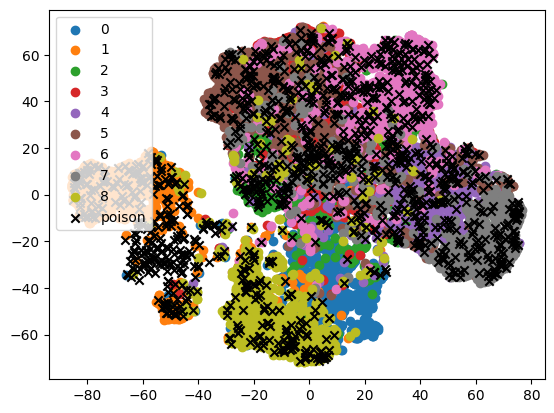

Epoch [101/1000]	
	Step [0/391]	 Loss: 3.60198
	Step [50/391]	 Loss: 3.60716
	Step [100/391]	 Loss: 3.60671
	Step [150/391]	 Loss: 3.60135
	Step [200/391]	 Loss: 3.60151
	Step [250/391]	 Loss: 3.60734
	Step [300/391]	 Loss: 3.60318
	Step [350/391]	 Loss: 3.60242
	Epoch [101/1000]	 Training Loss: 3.6051445976852454
	Epoch [101/1000]	 Time Taken: 4.001531008879343 minutes
Epoch [102/1000]	
	Step [0/391]	 Loss: 3.59535
	Step [50/391]	 Loss: 3.60485
	Step [100/391]	 Loss: 3.60675
	Step [150/391]	 Loss: 3.60559
	Step [200/391]	 Loss: 3.60417
	Step [250/391]	 Loss: 3.60718
	Step [300/391]	 Loss: 3.60808
	Step [350/391]	 Loss: 3.60875
	Epoch [102/1000]	 Training Loss: 3.6048855659601937
	Epoch [102/1000]	 Time Taken: 3.9899927377700806 minutes
Epoch [103/1000]	
	Step [0/391]	 Loss: 3.60234
	Step [50/391]	 Loss: 3.61347
	Step [100/391]	 Loss: 3.60731
	Step [150/391]	 Loss: 3.60547
	Step [200/391]	 Loss: 3.61361
	Step [250/391]	 Loss: 3.60962
	Step [300/391]	 Loss: 3.60333
	Step [350/391]	 Loss

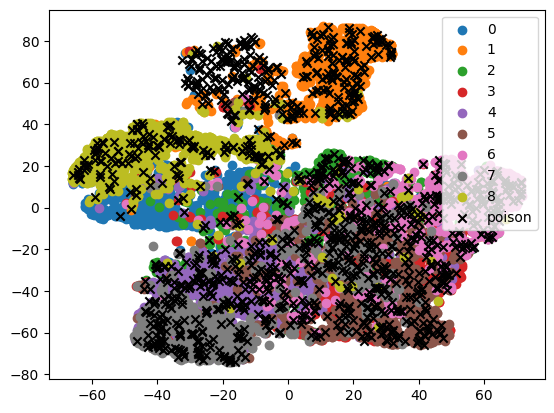

Epoch [111/1000]	
	Step [0/391]	 Loss: 3.599
	Step [50/391]	 Loss: 3.60635
	Step [100/391]	 Loss: 3.60702
	Step [150/391]	 Loss: 3.60521
	Step [200/391]	 Loss: 3.60666
	Step [250/391]	 Loss: 3.60379
	Step [300/391]	 Loss: 3.60506
	Step [350/391]	 Loss: 3.60579
	Epoch [111/1000]	 Training Loss: 3.603161637435484
	Epoch [111/1000]	 Time Taken: 3.98959512313207 minutes
Epoch [112/1000]	
	Step [0/391]	 Loss: 3.6033
	Step [50/391]	 Loss: 3.5989
	Step [100/391]	 Loss: 3.60634
	Step [150/391]	 Loss: 3.60189
	Step [200/391]	 Loss: 3.60648
	Step [250/391]	 Loss: 3.60173
	Step [300/391]	 Loss: 3.60319
	Step [350/391]	 Loss: 3.60332
	Epoch [112/1000]	 Training Loss: 3.6033354933609436
	Epoch [112/1000]	 Time Taken: 3.9939719637235007 minutes
Epoch [113/1000]	
	Step [0/391]	 Loss: 3.603
	Step [50/391]	 Loss: 3.60043
	Step [100/391]	 Loss: 3.60567
	Step [150/391]	 Loss: 3.60693
	Step [200/391]	 Loss: 3.60228
	Step [250/391]	 Loss: 3.60174
	Step [300/391]	 Loss: 3.59935
	Step [350/391]	 Loss: 3.6047

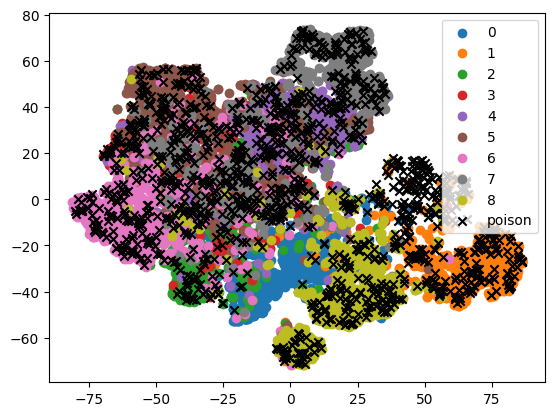

Epoch [121/1000]	
	Step [0/391]	 Loss: 3.60654
	Step [50/391]	 Loss: 3.59458
	Step [100/391]	 Loss: 3.60163
	Step [150/391]	 Loss: 3.60379
	Step [200/391]	 Loss: 3.60541
	Step [250/391]	 Loss: 3.59841
	Step [300/391]	 Loss: 3.60916
	Step [350/391]	 Loss: 3.59696
	Epoch [121/1000]	 Training Loss: 3.6015732087137753
	Epoch [121/1000]	 Time Taken: 3.99688751300176 minutes
Epoch [122/1000]	
	Step [0/391]	 Loss: 3.60289
	Step [50/391]	 Loss: 3.60118
	Step [100/391]	 Loss: 3.5975
	Step [150/391]	 Loss: 3.59891
	Step [200/391]	 Loss: 3.60651
	Step [250/391]	 Loss: 3.60269
	Step [300/391]	 Loss: 3.60769
	Step [350/391]	 Loss: 3.59928
	Epoch [122/1000]	 Training Loss: 3.6013398066810938
	Epoch [122/1000]	 Time Taken: 3.9930686990420026 minutes
Epoch [123/1000]	
	Step [0/391]	 Loss: 3.60084
	Step [50/391]	 Loss: 3.6016
	Step [100/391]	 Loss: 3.60278
	Step [150/391]	 Loss: 3.60253
	Step [200/391]	 Loss: 3.60508
	Step [250/391]	 Loss: 3.5985
	Step [300/391]	 Loss: 3.60426
	Step [350/391]	 Loss: 3.

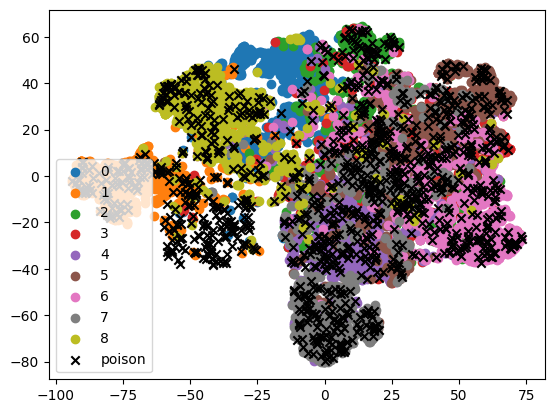

Epoch [131/1000]	
	Step [0/391]	 Loss: 3.60149
	Step [50/391]	 Loss: 3.59937
	Step [100/391]	 Loss: 3.60122
	Step [150/391]	 Loss: 3.60263
	Step [200/391]	 Loss: 3.597
	Step [250/391]	 Loss: 3.60056
	Step [300/391]	 Loss: 3.60425
	Step [350/391]	 Loss: 3.59815
	Epoch [131/1000]	 Training Loss: 3.599882778304312
	Epoch [131/1000]	 Time Taken: 3.9943785826365152 minutes
Epoch [132/1000]	
	Step [0/391]	 Loss: 3.60622
	Step [50/391]	 Loss: 3.59463
	Step [100/391]	 Loss: 3.60362
	Step [150/391]	 Loss: 3.60664
	Step [200/391]	 Loss: 3.61146
	Step [250/391]	 Loss: 3.60091
	Step [300/391]	 Loss: 3.59654
	Step [350/391]	 Loss: 3.59956
	Epoch [132/1000]	 Training Loss: 3.6000591232953476
	Epoch [132/1000]	 Time Taken: 3.9903971115748087 minutes
Epoch [133/1000]	
	Step [0/391]	 Loss: 3.60371
	Step [50/391]	 Loss: 3.59451
	Step [100/391]	 Loss: 3.5976
	Step [150/391]	 Loss: 3.59239
	Step [200/391]	 Loss: 3.59903
	Step [250/391]	 Loss: 3.59861
	Step [300/391]	 Loss: 3.59683
	Step [350/391]	 Loss: 3

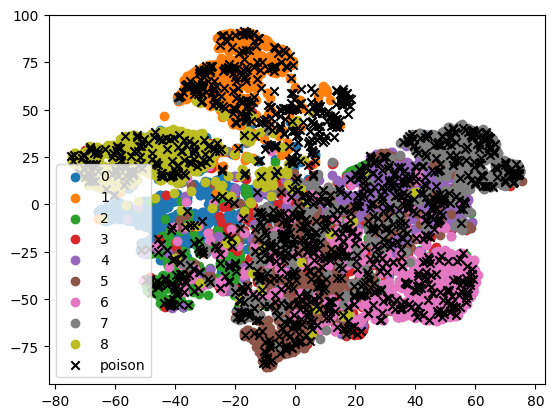

Epoch [141/1000]	
	Step [0/391]	 Loss: 3.60005
	Step [50/391]	 Loss: 3.59887
	Step [100/391]	 Loss: 3.60035
	Step [150/391]	 Loss: 3.61269
	Step [200/391]	 Loss: 3.59981
	Step [250/391]	 Loss: 3.59643
	Step [300/391]	 Loss: 3.60099
	Step [350/391]	 Loss: 3.59669
	Epoch [141/1000]	 Training Loss: 3.598776310606076
	Epoch [141/1000]	 Time Taken: 3.993410845597585 minutes
Epoch [142/1000]	
	Step [0/391]	 Loss: 3.59889
	Step [50/391]	 Loss: 3.59084
	Step [100/391]	 Loss: 3.60319
	Step [150/391]	 Loss: 3.60334
	Step [200/391]	 Loss: 3.60402
	Step [250/391]	 Loss: 3.59778
	Step [300/391]	 Loss: 3.59983
	Step [350/391]	 Loss: 3.60577
	Epoch [142/1000]	 Training Loss: 3.5987955871445445
	Epoch [142/1000]	 Time Taken: 4.003547112147014 minutes
Epoch [143/1000]	
	Step [0/391]	 Loss: 3.59926
	Step [50/391]	 Loss: 3.59526
	Step [100/391]	 Loss: 3.59798
	Step [150/391]	 Loss: 3.60427
	Step [200/391]	 Loss: 3.59279
	Step [250/391]	 Loss: 3.60316
	Step [300/391]	 Loss: 3.59857
	Step [350/391]	 Loss: 

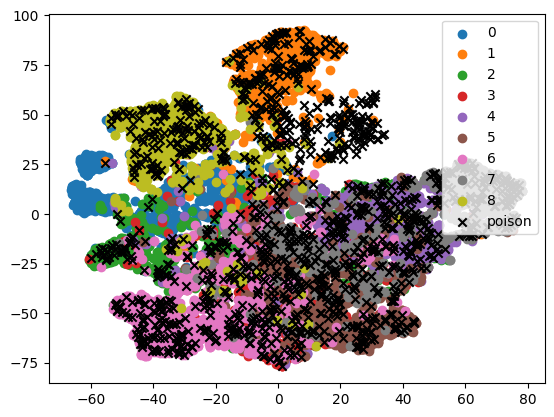

Epoch [151/1000]	
	Step [0/391]	 Loss: 3.59617
	Step [50/391]	 Loss: 3.59709
	Step [100/391]	 Loss: 3.59911
	Step [150/391]	 Loss: 3.59177
	Step [200/391]	 Loss: 3.60764
	Step [250/391]	 Loss: 3.59725
	Step [300/391]	 Loss: 3.60292
	Step [350/391]	 Loss: 3.5989
	Epoch [151/1000]	 Training Loss: 3.5974024543371956
	Epoch [151/1000]	 Time Taken: 3.9911889314651487 minutes
Epoch [152/1000]	
	Step [0/391]	 Loss: 3.59896
	Step [50/391]	 Loss: 3.5938
	Step [100/391]	 Loss: 3.59727
	Step [150/391]	 Loss: 3.60097
	Step [200/391]	 Loss: 3.59296
	Step [250/391]	 Loss: 3.59588
	Step [300/391]	 Loss: 3.59939
	Step [350/391]	 Loss: 3.60057
	Epoch [152/1000]	 Training Loss: 3.5975065719136192
	Epoch [152/1000]	 Time Taken: 3.9953086495399477 minutes
Epoch [153/1000]	
	Step [0/391]	 Loss: 3.59923
	Step [50/391]	 Loss: 3.59755
	Step [100/391]	 Loss: 3.59635
	Step [150/391]	 Loss: 3.58734
	Step [200/391]	 Loss: 3.59985
	Step [250/391]	 Loss: 3.60111
	Step [300/391]	 Loss: 3.59702
	Step [350/391]	 Loss:

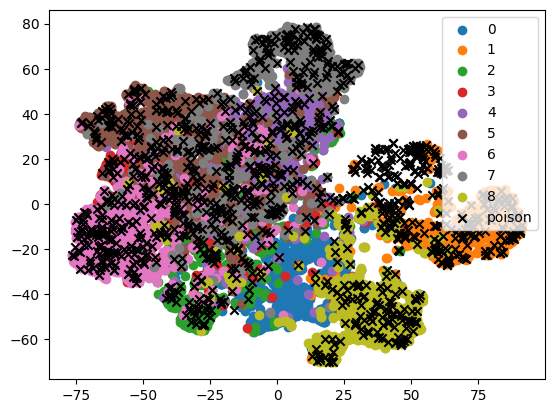

Epoch [161/1000]	
	Step [0/391]	 Loss: 3.59576
	Step [50/391]	 Loss: 3.59661
	Step [100/391]	 Loss: 3.59591
	Step [150/391]	 Loss: 3.59804
	Step [200/391]	 Loss: 3.59852
	Step [250/391]	 Loss: 3.60337
	Step [300/391]	 Loss: 3.60098
	Step [350/391]	 Loss: 3.59283
	Epoch [161/1000]	 Training Loss: 3.596472561511847
	Epoch [161/1000]	 Time Taken: 3.997804582118988 minutes
Epoch [162/1000]	
	Step [0/391]	 Loss: 3.59794
	Step [50/391]	 Loss: 3.59832
	Step [100/391]	 Loss: 3.596
	Step [150/391]	 Loss: 3.59547
	Step [200/391]	 Loss: 3.60093
	Step [250/391]	 Loss: 3.59581
	Step [300/391]	 Loss: 3.59851
	Step [350/391]	 Loss: 3.59329
	Epoch [162/1000]	 Training Loss: 3.5960578790406132
	Epoch [162/1000]	 Time Taken: 3.9802050471305845 minutes
Epoch [163/1000]	
	Step [0/391]	 Loss: 3.59584
	Step [50/391]	 Loss: 3.59646
	Step [100/391]	 Loss: 3.59681
	Step [150/391]	 Loss: 3.59456
	Step [200/391]	 Loss: 3.59078
	Step [250/391]	 Loss: 3.59892
	Step [300/391]	 Loss: 3.59544
	Step [350/391]	 Loss: 3

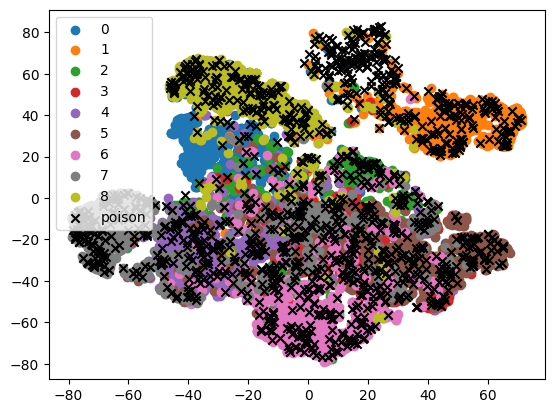

Epoch [171/1000]	
	Step [0/391]	 Loss: 3.59294
	Step [50/391]	 Loss: 3.59678
	Step [100/391]	 Loss: 3.59501
	Step [150/391]	 Loss: 3.59684
	Step [200/391]	 Loss: 3.60157
	Step [250/391]	 Loss: 3.59739
	Step [300/391]	 Loss: 3.59256
	Step [350/391]	 Loss: 3.59764
	Epoch [171/1000]	 Training Loss: 3.595172429633567
	Epoch [171/1000]	 Time Taken: 3.9830185055732725 minutes
Epoch [172/1000]	
	Step [0/391]	 Loss: 3.59266
	Step [50/391]	 Loss: 3.59454
	Step [100/391]	 Loss: 3.59251
	Step [150/391]	 Loss: 3.59871
	Step [200/391]	 Loss: 3.59633
	Step [250/391]	 Loss: 3.59184
	Step [300/391]	 Loss: 3.59518
	Step [350/391]	 Loss: 3.59587
	Epoch [172/1000]	 Training Loss: 3.5946478648563787
	Epoch [172/1000]	 Time Taken: 3.974743644396464 minutes
Epoch [173/1000]	
	Step [0/391]	 Loss: 3.6012
	Step [50/391]	 Loss: 3.59869
	Step [100/391]	 Loss: 3.5976
	Step [150/391]	 Loss: 3.59419
	Step [200/391]	 Loss: 3.59536
	Step [250/391]	 Loss: 3.59982
	Step [300/391]	 Loss: 3.59587
	Step [350/391]	 Loss: 3

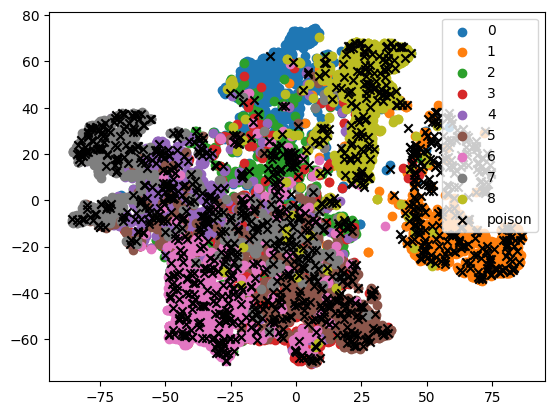

Epoch [181/1000]	
	Step [0/391]	 Loss: 3.60026
	Step [50/391]	 Loss: 3.59214
	Step [100/391]	 Loss: 3.59592
	Step [150/391]	 Loss: 3.59578
	Step [200/391]	 Loss: 3.60115
	Step [250/391]	 Loss: 3.59501
	Step [300/391]	 Loss: 3.60001
	Step [350/391]	 Loss: 3.59339
	Epoch [181/1000]	 Training Loss: 3.594154521327494
	Epoch [181/1000]	 Time Taken: 3.993413817882538 minutes
Epoch [182/1000]	
	Step [0/391]	 Loss: 3.59816
	Step [50/391]	 Loss: 3.6001
	Step [100/391]	 Loss: 3.5977
	Step [150/391]	 Loss: 3.59168
	Step [200/391]	 Loss: 3.60124
	Step [250/391]	 Loss: 3.5975
	Step [300/391]	 Loss: 3.59475
	Step [350/391]	 Loss: 3.59535
	Epoch [182/1000]	 Training Loss: 3.593640918926815
	Epoch [182/1000]	 Time Taken: 3.9236976583798726 minutes
Epoch [183/1000]	
	Step [0/391]	 Loss: 3.59563
	Step [50/391]	 Loss: 3.59274
	Step [100/391]	 Loss: 3.59323
	Step [150/391]	 Loss: 3.60197
	Step [200/391]	 Loss: 3.59517
	Step [250/391]	 Loss: 3.59364
	Step [300/391]	 Loss: 3.59575
	Step [350/391]	 Loss: 3.5

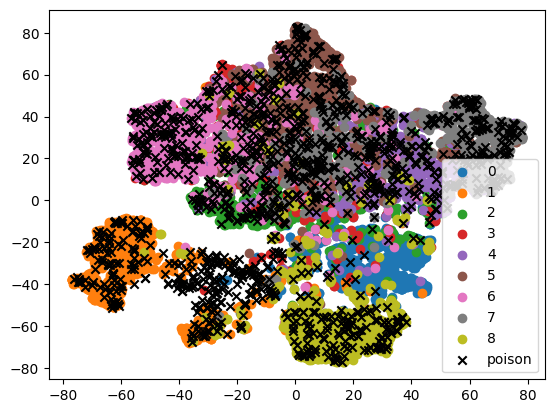

Epoch [191/1000]	
	Step [0/391]	 Loss: 3.59087
	Step [50/391]	 Loss: 3.58971
	Step [100/391]	 Loss: 3.59047
	Step [150/391]	 Loss: 3.59351
	Step [200/391]	 Loss: 3.59657
	Step [250/391]	 Loss: 3.59031
	Step [300/391]	 Loss: 3.59074
	Step [350/391]	 Loss: 3.59073
	Epoch [191/1000]	 Training Loss: 3.592631755277629
	Epoch [191/1000]	 Time Taken: 3.9952487468719484 minutes
Epoch [192/1000]	
	Step [0/391]	 Loss: 3.59633
	Step [50/391]	 Loss: 3.59527
	Step [100/391]	 Loss: 3.58895
	Step [150/391]	 Loss: 3.59204
	Step [200/391]	 Loss: 3.59415
	Step [250/391]	 Loss: 3.59504
	Step [300/391]	 Loss: 3.58793
	Step [350/391]	 Loss: 3.60087
	Epoch [192/1000]	 Training Loss: 3.593058597706163
	Epoch [192/1000]	 Time Taken: 3.992865459124247 minutes
Epoch [193/1000]	
	Step [0/391]	 Loss: 3.60063
	Step [50/391]	 Loss: 3.5882
	Step [100/391]	 Loss: 3.59371
	Step [150/391]	 Loss: 3.58449
	Step [200/391]	 Loss: 3.58836
	Step [250/391]	 Loss: 3.58859
	Step [300/391]	 Loss: 3.59313
	Step [350/391]	 Loss: 3

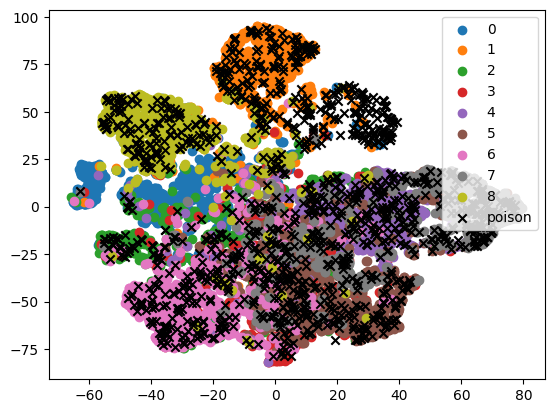

Epoch [201/1000]	
	Step [0/391]	 Loss: 3.59382
	Step [50/391]	 Loss: 3.59287
	Step [100/391]	 Loss: 3.58778
	Step [150/391]	 Loss: 3.59251
	Step [200/391]	 Loss: 3.59337
	Step [250/391]	 Loss: 3.58862
	Step [300/391]	 Loss: 3.59572
	Step [350/391]	 Loss: 3.58977
	Epoch [201/1000]	 Training Loss: 3.5916314100670386
	Epoch [201/1000]	 Time Taken: 4.033232406775157 minutes
Epoch [202/1000]	
	Step [0/391]	 Loss: 3.59007
	Step [50/391]	 Loss: 3.59346
	Step [100/391]	 Loss: 3.59054
	Step [150/391]	 Loss: 3.59641
	Step [200/391]	 Loss: 3.59148
	Step [250/391]	 Loss: 3.59167
	Step [300/391]	 Loss: 3.59107
	Step [350/391]	 Loss: 3.59254
	Epoch [202/1000]	 Training Loss: 3.5917743380417297
	Epoch [202/1000]	 Time Taken: 3.990549604098002 minutes
Epoch [203/1000]	
	Step [0/391]	 Loss: 3.58936
	Step [50/391]	 Loss: 3.59078
	Step [100/391]	 Loss: 3.59595
	Step [150/391]	 Loss: 3.58779
	Step [200/391]	 Loss: 3.5944
	Step [250/391]	 Loss: 3.59708
	Step [300/391]	 Loss: 3.58945
	Step [350/391]	 Loss: 

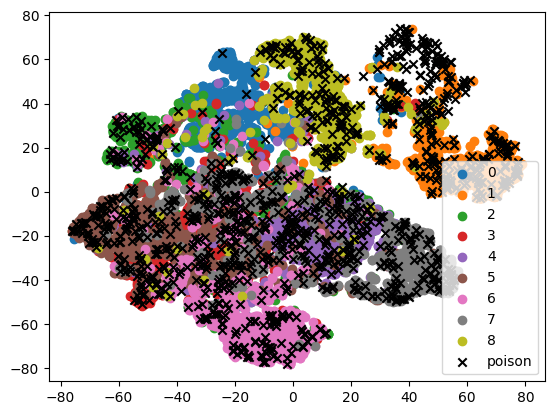

Epoch [211/1000]	
	Step [0/391]	 Loss: 3.59175
	Step [50/391]	 Loss: 3.5927
	Step [100/391]	 Loss: 3.59073
	Step [150/391]	 Loss: 3.58882
	Step [200/391]	 Loss: 3.5904
	Step [250/391]	 Loss: 3.58943
	Step [300/391]	 Loss: 3.59709
	Step [350/391]	 Loss: 3.59547
	Epoch [211/1000]	 Training Loss: 3.5910074710845947
	Epoch [211/1000]	 Time Taken: 4.0002162535985315 minutes
Epoch [212/1000]	
	Step [0/391]	 Loss: 3.59263
	Step [50/391]	 Loss: 3.59225
	Step [100/391]	 Loss: 3.59247
	Step [150/391]	 Loss: 3.59368
	Step [200/391]	 Loss: 3.59099
	Step [250/391]	 Loss: 3.59385
	Step [300/391]	 Loss: 3.59456
	Step [350/391]	 Loss: 3.58975
	Epoch [212/1000]	 Training Loss: 3.5908119032145156
	Epoch [212/1000]	 Time Taken: 3.9961663206418354 minutes
Epoch [213/1000]	
	Step [0/391]	 Loss: 3.59234
	Step [50/391]	 Loss: 3.59062
	Step [100/391]	 Loss: 3.59264
	Step [150/391]	 Loss: 3.59068
	Step [200/391]	 Loss: 3.59076
	Step [250/391]	 Loss: 3.59333
	Step [300/391]	 Loss: 3.58849
	Step [350/391]	 Loss:

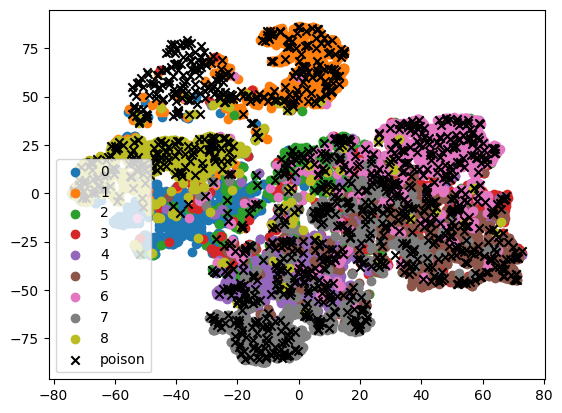

Epoch [221/1000]	
	Step [0/391]	 Loss: 3.5936
	Step [50/391]	 Loss: 3.59339
	Step [100/391]	 Loss: 3.59152
	Step [150/391]	 Loss: 3.59067
	Step [200/391]	 Loss: 3.58769
	Step [250/391]	 Loss: 3.59834
	Step [300/391]	 Loss: 3.59192
	Step [350/391]	 Loss: 3.59896
	Epoch [221/1000]	 Training Loss: 3.589729908482193
	Epoch [221/1000]	 Time Taken: 3.998800003528595 minutes
Epoch [222/1000]	
	Step [0/391]	 Loss: 3.5916
	Step [50/391]	 Loss: 3.5872
	Step [100/391]	 Loss: 3.59621
	Step [150/391]	 Loss: 3.58523
	Step [200/391]	 Loss: 3.58604
	Step [250/391]	 Loss: 3.59058
	Step [300/391]	 Loss: 3.59002
	Step [350/391]	 Loss: 3.59207
	Epoch [222/1000]	 Training Loss: 3.5897944077201513
	Epoch [222/1000]	 Time Taken: 3.999150002002716 minutes
Epoch [223/1000]	
	Step [0/391]	 Loss: 3.59037
	Step [50/391]	 Loss: 3.58752
	Step [100/391]	 Loss: 3.58972
	Step [150/391]	 Loss: 3.58856
	Step [200/391]	 Loss: 3.58629
	Step [250/391]	 Loss: 3.58776
	Step [300/391]	 Loss: 3.59144
	Step [350/391]	 Loss: 3.5

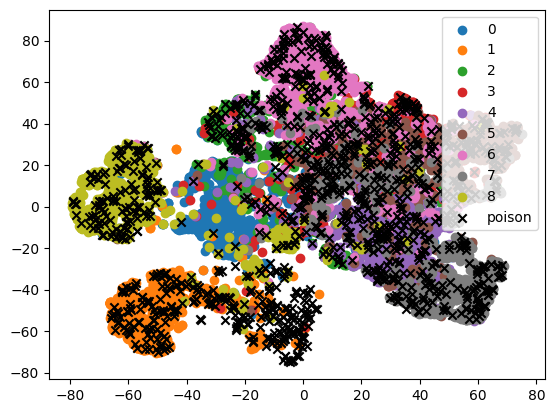

Epoch [231/1000]	
	Step [0/391]	 Loss: 3.58857
	Step [50/391]	 Loss: 3.58566
	Step [100/391]	 Loss: 3.59188
	Step [150/391]	 Loss: 3.60164
	Step [200/391]	 Loss: 3.58468
	Step [250/391]	 Loss: 3.58822
	Step [300/391]	 Loss: 3.58756
	Step [350/391]	 Loss: 3.58706
	Epoch [231/1000]	 Training Loss: 3.5890524442238574
	Epoch [231/1000]	 Time Taken: 3.99724950393041 minutes
Epoch [232/1000]	
	Step [0/391]	 Loss: 3.59151
	Step [50/391]	 Loss: 3.58816
	Step [100/391]	 Loss: 3.59094
	Step [150/391]	 Loss: 3.58836
	Step [200/391]	 Loss: 3.59009
	Step [250/391]	 Loss: 3.59571
	Step [300/391]	 Loss: 3.58921
	Step [350/391]	 Loss: 3.58481
	Epoch [232/1000]	 Training Loss: 3.5891207874278583
	Epoch [232/1000]	 Time Taken: 3.999049985408783 minutes
Epoch [233/1000]	
	Step [0/391]	 Loss: 3.59149
	Step [50/391]	 Loss: 3.5891
	Step [100/391]	 Loss: 3.58831
	Step [150/391]	 Loss: 3.5875
	Step [200/391]	 Loss: 3.59586
	Step [250/391]	 Loss: 3.58794
	Step [300/391]	 Loss: 3.58833
	Step [350/391]	 Loss: 3.

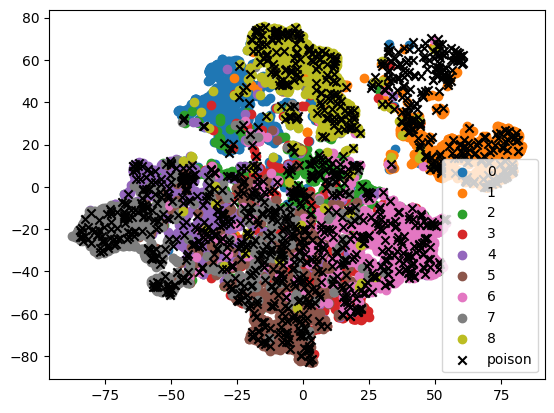

Epoch [241/1000]	
	Step [0/391]	 Loss: 3.58619
	Step [50/391]	 Loss: 3.59451
	Step [100/391]	 Loss: 3.59189
	Step [150/391]	 Loss: 3.59293
	Step [200/391]	 Loss: 3.59141
	Step [250/391]	 Loss: 3.59278
	Step [300/391]	 Loss: 3.58489
	Step [350/391]	 Loss: 3.58918
	Epoch [241/1000]	 Training Loss: 3.588230043421011
	Epoch [241/1000]	 Time Taken: 3.9997690478960672 minutes
Epoch [242/1000]	
	Step [0/391]	 Loss: 3.59176
	Step [50/391]	 Loss: 3.59193
	Step [100/391]	 Loss: 3.59004
	Step [150/391]	 Loss: 3.58902
	Step [200/391]	 Loss: 3.58666
	Step [250/391]	 Loss: 3.58903
	Step [300/391]	 Loss: 3.58835
	Step [350/391]	 Loss: 3.58354
	Epoch [242/1000]	 Training Loss: 3.588019911895323
	Epoch [242/1000]	 Time Taken: 3.9837873379389444 minutes
Epoch [243/1000]	
	Step [0/391]	 Loss: 3.59086
	Step [50/391]	 Loss: 3.58728
	Step [100/391]	 Loss: 3.58973
	Step [150/391]	 Loss: 3.59335
	Step [200/391]	 Loss: 3.5925
	Step [250/391]	 Loss: 3.58431
	Step [300/391]	 Loss: 3.59078
	Step [350/391]	 Loss: 

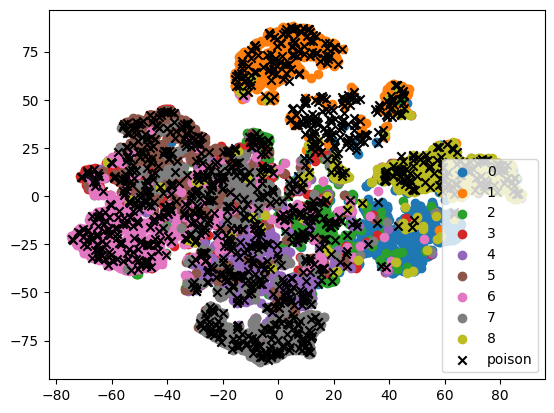

Epoch [251/1000]	
	Step [0/391]	 Loss: 3.59323
	Step [50/391]	 Loss: 3.58961
	Step [100/391]	 Loss: 3.59142
	Step [150/391]	 Loss: 3.58645
	Step [200/391]	 Loss: 3.59239
	Step [250/391]	 Loss: 3.5851
	Step [300/391]	 Loss: 3.58663
	Step [350/391]	 Loss: 3.58984
	Epoch [251/1000]	 Training Loss: 3.5875775222583197
	Epoch [251/1000]	 Time Taken: 3.982203121980031 minutes
Epoch [252/1000]	
	Step [0/391]	 Loss: 3.59318
	Step [50/391]	 Loss: 3.587
	Step [100/391]	 Loss: 3.58313
	Step [150/391]	 Loss: 3.59292
	Step [200/391]	 Loss: 3.58376
	Step [250/391]	 Loss: 3.5874
	Step [300/391]	 Loss: 3.58846
	Step [350/391]	 Loss: 3.58877
	Epoch [252/1000]	 Training Loss: 3.5874755254486943
	Epoch [252/1000]	 Time Taken: 3.9929364562034606 minutes
Epoch [253/1000]	
	Step [0/391]	 Loss: 3.58927
	Step [50/391]	 Loss: 3.5861
	Step [100/391]	 Loss: 3.58764
	Step [150/391]	 Loss: 3.58844
	Step [200/391]	 Loss: 3.58679
	Step [250/391]	 Loss: 3.58806
	Step [300/391]	 Loss: 3.59631
	Step [350/391]	 Loss: 3.5

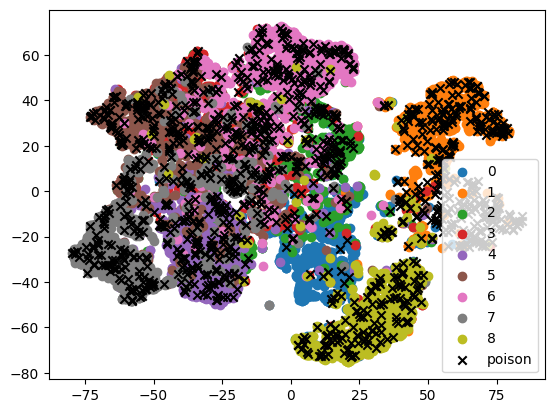

Epoch [261/1000]	
	Step [0/391]	 Loss: 3.58535
	Step [50/391]	 Loss: 3.58307
	Step [100/391]	 Loss: 3.59127
	Step [150/391]	 Loss: 3.58653
	Step [200/391]	 Loss: 3.58897
	Step [250/391]	 Loss: 3.58925
	Step [300/391]	 Loss: 3.5905
	Step [350/391]	 Loss: 3.5861
	Epoch [261/1000]	 Training Loss: 3.586601368911431
	Epoch [261/1000]	 Time Taken: 3.9914384881655374 minutes
Epoch [262/1000]	
	Step [0/391]	 Loss: 3.58875
	Step [50/391]	 Loss: 3.59127
	Step [100/391]	 Loss: 3.58699
	Step [150/391]	 Loss: 3.59121
	Step [200/391]	 Loss: 3.58959
	Step [250/391]	 Loss: 3.58723
	Step [300/391]	 Loss: 3.58902
	Step [350/391]	 Loss: 3.59059
	Epoch [262/1000]	 Training Loss: 3.5869214516466537
	Epoch [262/1000]	 Time Taken: 4.001675037542979 minutes
Epoch [263/1000]	
	Step [0/391]	 Loss: 3.58881
	Step [50/391]	 Loss: 3.58687
	Step [100/391]	 Loss: 3.58962
	Step [150/391]	 Loss: 3.58508
	Step [200/391]	 Loss: 3.5872
	Step [250/391]	 Loss: 3.59109
	Step [300/391]	 Loss: 3.58534
	Step [350/391]	 Loss: 3.

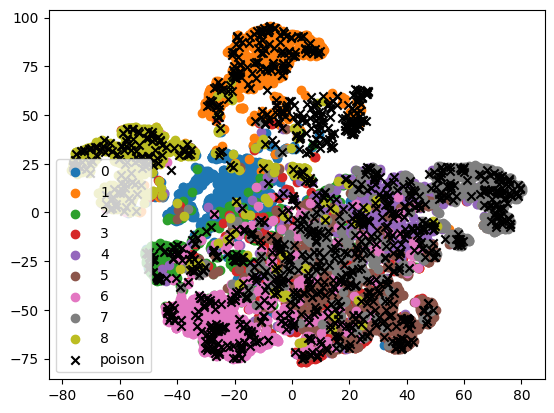

Epoch [271/1000]	
	Step [0/391]	 Loss: 3.5861
	Step [50/391]	 Loss: 3.58618
	Step [100/391]	 Loss: 3.59176
	Step [150/391]	 Loss: 3.58928
	Step [200/391]	 Loss: 3.58717
	Step [250/391]	 Loss: 3.58814
	Step [300/391]	 Loss: 3.58575
	Step [350/391]	 Loss: 3.5854
	Epoch [271/1000]	 Training Loss: 3.5859452354938477
	Epoch [271/1000]	 Time Taken: 3.9862934311230975 minutes
Epoch [272/1000]	
	Step [0/391]	 Loss: 3.58735
	Step [50/391]	 Loss: 3.59073
	Step [100/391]	 Loss: 3.59328
	Step [150/391]	 Loss: 3.58493
	Step [200/391]	 Loss: 3.58499
	Step [250/391]	 Loss: 3.59018
	Step [300/391]	 Loss: 3.58476
	Step [350/391]	 Loss: 3.58743
	Epoch [272/1000]	 Training Loss: 3.586076027901886
	Epoch [272/1000]	 Time Taken: 3.9850428700447083 minutes
Epoch [273/1000]	
	Step [0/391]	 Loss: 3.58422
	Step [50/391]	 Loss: 3.59064
	Step [100/391]	 Loss: 3.5948
	Step [150/391]	 Loss: 3.585
	Step [200/391]	 Loss: 3.58717
	Step [250/391]	 Loss: 3.58447
	Step [300/391]	 Loss: 3.59057
	Step [350/391]	 Loss: 3.5

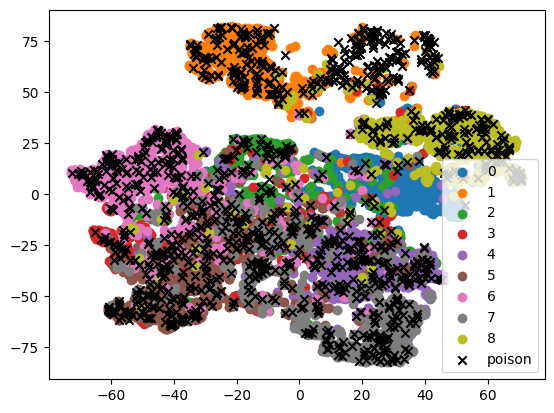

Epoch [281/1000]	
	Step [0/391]	 Loss: 3.58847
	Step [50/391]	 Loss: 3.58734
	Step [100/391]	 Loss: 3.58474
	Step [150/391]	 Loss: 3.58755
	Step [200/391]	 Loss: 3.58483
	Step [250/391]	 Loss: 3.59236
	Step [300/391]	 Loss: 3.5881
	Step [350/391]	 Loss: 3.58646
	Epoch [281/1000]	 Training Loss: 3.5857487773651355
	Epoch [281/1000]	 Time Taken: 3.991244200865428 minutes
Epoch [282/1000]	
	Step [0/391]	 Loss: 3.58628
	Step [50/391]	 Loss: 3.58947
	Step [100/391]	 Loss: 3.58849
	Step [150/391]	 Loss: 3.58514
	Step [200/391]	 Loss: 3.58745
	Step [250/391]	 Loss: 3.58273
	Step [300/391]	 Loss: 3.58812
	Step [350/391]	 Loss: 3.58773
	Epoch [282/1000]	 Training Loss: 3.5855362829954727
	Epoch [282/1000]	 Time Taken: 3.986178441842397 minutes
Epoch [283/1000]	
	Step [0/391]	 Loss: 3.5856
	Step [50/391]	 Loss: 3.58741
	Step [100/391]	 Loss: 3.58587
	Step [150/391]	 Loss: 3.58928
	Step [200/391]	 Loss: 3.58794
	Step [250/391]	 Loss: 3.58731
	Step [300/391]	 Loss: 3.58402
	Step [350/391]	 Loss: 3

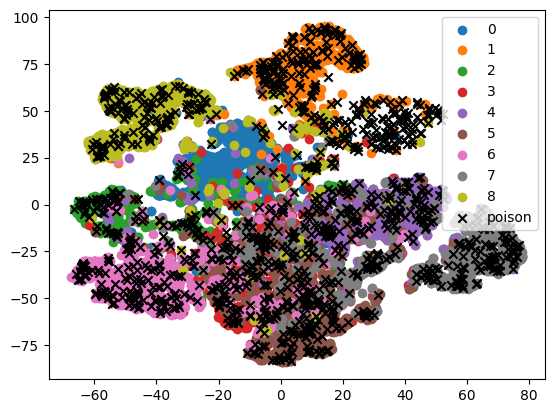

Epoch [291/1000]	
	Step [0/391]	 Loss: 3.58379
	Step [50/391]	 Loss: 3.58845
	Step [100/391]	 Loss: 3.58482
	Step [150/391]	 Loss: 3.58308
	Step [200/391]	 Loss: 3.58142
	Step [250/391]	 Loss: 3.58669
	Step [300/391]	 Loss: 3.58779
	Step [350/391]	 Loss: 3.59105
	Epoch [291/1000]	 Training Loss: 3.584804123319933
	Epoch [291/1000]	 Time Taken: 3.983537908395131 minutes
Epoch [292/1000]	
	Step [0/391]	 Loss: 3.58113
	Step [50/391]	 Loss: 3.58718
	Step [100/391]	 Loss: 3.58521
	Step [150/391]	 Loss: 3.58371
	Step [200/391]	 Loss: 3.58684
	Step [250/391]	 Loss: 3.58222
	Step [300/391]	 Loss: 3.5824
	Step [350/391]	 Loss: 3.58832
	Epoch [292/1000]	 Training Loss: 3.584846600852049
	Epoch [292/1000]	 Time Taken: 3.9859058539072674 minutes
Epoch [293/1000]	
	Step [0/391]	 Loss: 3.5865
	Step [50/391]	 Loss: 3.58665
	Step [100/391]	 Loss: 3.58561
	Step [150/391]	 Loss: 3.58694
	Step [200/391]	 Loss: 3.58637
	Step [250/391]	 Loss: 3.58478
	Step [300/391]	 Loss: 3.58583
	Step [350/391]	 Loss: 3.

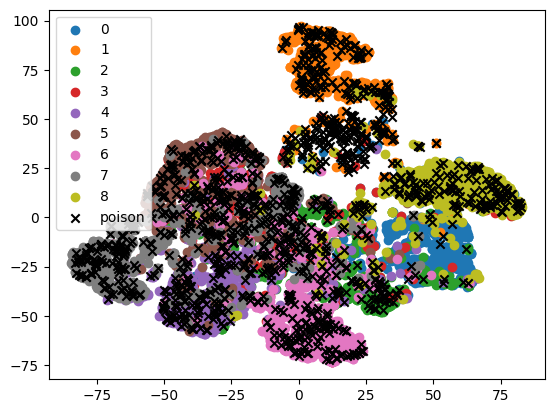

Epoch [301/1000]	
	Step [0/391]	 Loss: 3.58469
	Step [50/391]	 Loss: 3.5856
	Step [100/391]	 Loss: 3.58593
	Step [150/391]	 Loss: 3.58325
	Step [200/391]	 Loss: 3.5851
	Step [250/391]	 Loss: 3.5898
	Step [300/391]	 Loss: 3.58614
	Step [350/391]	 Loss: 3.58577
	Epoch [301/1000]	 Training Loss: 3.5844351342876855
	Epoch [301/1000]	 Time Taken: 3.985992749532064 minutes
Epoch [302/1000]	
	Step [0/391]	 Loss: 3.58686
	Step [50/391]	 Loss: 3.58671
	Step [100/391]	 Loss: 3.58399
	Step [150/391]	 Loss: 3.58938
	Step [200/391]	 Loss: 3.58641
	Step [250/391]	 Loss: 3.58528
	Step [300/391]	 Loss: 3.5859
	Step [350/391]	 Loss: 3.58277
	Epoch [302/1000]	 Training Loss: 3.5843281495906507
	Epoch [302/1000]	 Time Taken: 3.988142744700114 minutes
Epoch [303/1000]	
	Step [0/391]	 Loss: 3.58743
	Step [50/391]	 Loss: 3.58845
	Step [100/391]	 Loss: 3.58827
	Step [150/391]	 Loss: 3.58788
	Step [200/391]	 Loss: 3.58239
	Step [250/391]	 Loss: 3.58699
	Step [300/391]	 Loss: 3.58559
	Step [350/391]	 Loss: 3.5

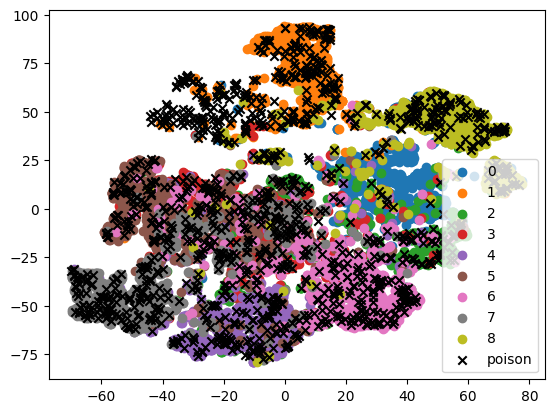

Epoch [311/1000]	
	Step [0/391]	 Loss: 3.5827
	Step [50/391]	 Loss: 3.58459
	Step [100/391]	 Loss: 3.58524
	Step [150/391]	 Loss: 3.58531
	Step [200/391]	 Loss: 3.58392
	Step [250/391]	 Loss: 3.58222
	Step [300/391]	 Loss: 3.58319
	Step [350/391]	 Loss: 3.58767
	Epoch [311/1000]	 Training Loss: 3.58385872414045
	Epoch [311/1000]	 Time Taken: 3.995343792438507 minutes
Epoch [312/1000]	
	Step [0/391]	 Loss: 3.58548
	Step [50/391]	 Loss: 3.58224
	Step [100/391]	 Loss: 3.58418
	Step [150/391]	 Loss: 3.58823
	Step [200/391]	 Loss: 3.58226
	Step [250/391]	 Loss: 3.58531
	Step [300/391]	 Loss: 3.5885
	Step [350/391]	 Loss: 3.58224
	Epoch [312/1000]	 Training Loss: 3.583871417033398
	Epoch [312/1000]	 Time Taken: 3.9760520259539285 minutes
Epoch [313/1000]	
	Step [0/391]	 Loss: 3.58524
	Step [50/391]	 Loss: 3.58562
	Step [100/391]	 Loss: 3.58341
	Step [150/391]	 Loss: 3.58202
	Step [200/391]	 Loss: 3.58275
	Step [250/391]	 Loss: 3.58334
	Step [300/391]	 Loss: 3.58675
	Step [350/391]	 Loss: 3.5

KeyboardInterrupt: 

In [132]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"SimCLR_{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"SimCLR_{epochs}.pt")